# Annulus different distributions

In [1]:
using Pkg
Pkg.activate("../env/.")
Pkg.instantiate()

  Activating project at `~/analogous_neural/env`


In [2]:
include("../src/analogous_bars.jl")
include("../src/Eirene_var.jl")

using .analogous_bars
using .Eirene_var
using DelimitedFiles
using Plots
using CSV
using Distances
using HDF5
using FileIO

WebIO._IJuliaInit()

# 1. Load data 

In [4]:
# load points
results = load("data/annulus_different_distributions/two_circles.jld")
points = results["points"]
n_small = results["n_small"]
n_large = results["n_large"]

P = points[1:n_small,:] # points from small circle
Q = points[n_small+1:end, :]; # points from large circle

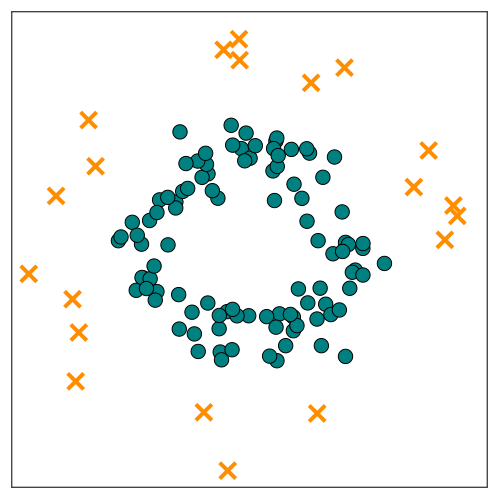

In [5]:
# plot P
p = plot(framestyle = :box, yaxis = nothing, xaxis = nothing,
        size = (500, 500), xlims = (-2.3, 2.3), ylims = (-2.7, 2.6))

scatter!(p,P[:,1], P[:,2], color = "#008181", 
            label = "", 
            markersize = 8, 
            marker = :circle)

# plot Q
scatter!(p, Q[:,1], Q[:,2], color = "#ff8d00", 
            label = "", 
            markersize = 8, 
            marker = :xcross,
            markerstrokewidth = 4
            )
#savefig("data/annulus_different_distributions/points.pdf")
plot(p)

In [6]:
# compute distances among points
P_all = vcat(P, Q)
D = pairwise(Euclidean(), transpose(P_all), transpose(P_all), dims=2)

# Define submatrices 
D_P = D[1:n_small, 1:n_small]
D_Q = D[n_small+1:end, n_small+1:end]
D_P_Q = D[1:n_small, n_small+1:end]
    # rows (landmarks): P
    # columns (witness) : Q
D_Q_P = D[n_small+1:end, 1:n_small];
    # rows (landmarks): Q
    # columns (witness) : P

In [7]:
# Compute Vietoris-Rips persistence on two regions
dim = 1
VR_P = eirene(D_P, record = "all", maxdim = dim)
VR_Q = eirene(D_Q, record = "all", maxdim = dim)

# compute Witness persistence
W_P = compute_Witness_persistence(D_P_Q, maxdim = dim);

In [8]:
# plot all PD
barcode_VR_P = barcode(VR_P, dim = 1)
barcode_W_P = barcode(W_P["eirene_output"], dim = 1)
barcode_VR_Q = barcode(VR_Q, dim = 1);

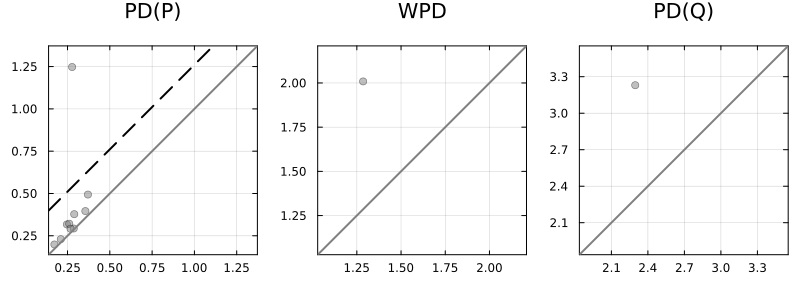

In [9]:
# plot all PD

selected_P, cutoff_P = select_persistent_intervals_IQR(barcode_VR_P)
p1 = plot_PD(barcode_VR_P, cutoff = cutoff_P, title = "PD(P)")
p2 = plot_PD(barcode_W_P, title = "WPD")
p3 = plot_PD(barcode_VR_Q, title = "PD(Q)")
plot(p1, p2, p3, layout = grid(1,3), size = (800, 300))

# Compute analogous cycles

In [10]:
analogous_P, analogous_Q = run_baseline_similarity_analogous(;
                                                                VR_P = VR_P,
                                                                D_P = D_P, 
                                                                VR_Q = VR_Q,
                                                                D_Q = D_Q, 
                                                                W_PQ = W_P, 
                                                                W_PQ_bars = [1]);

In [16]:
for i in keys(analogous_P)
    println("Analogous pair: ")
    println("In P: ", analogous_P[i]["baseline_bar_extension"])
    println("In Q: ", analogous_Q[i]["baseline_bar_extension"])
end

Analogous pair: 
In P: [8]
In Q: [1]


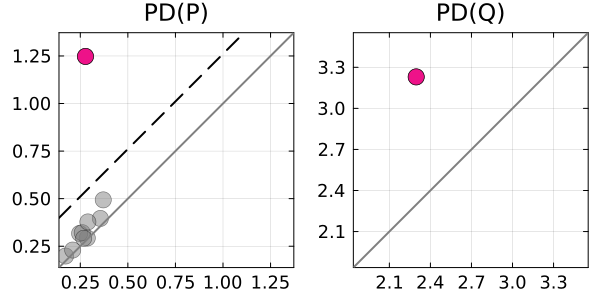

In [17]:
# plot all persistence diagrams & significance feature cutoff
p1 = plot_PD(barcode_VR_P; 
            highlight = [8],
            cutoff = cutoff_P,
            title = "PD(P)", 
            titlefontsize = 16,
            tickfontsize = 12,
            markersize = 9)

p2 = plot_PD(barcode_VR_Q; 
            highlight = [1],
            title = "PD(Q)", 
             markersize = 9,
            tickfontsize = 12,
            titlefontsize = 16)

plot(p1, p2, layout = grid(1,2), size = (600, 300))
#savefig("data/annulus_different_distributions/analogous_cycles.pdf")

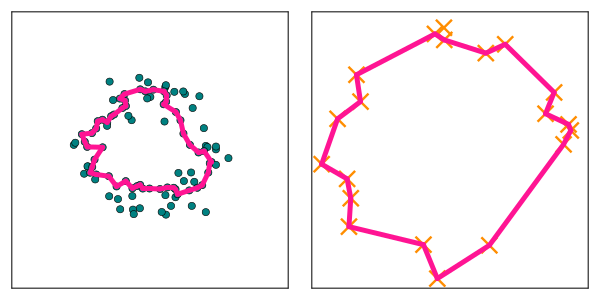

In [18]:
cr_P = get_cyclerep_Eirene(VR_P, 8)
cr_Q = get_cyclerep_Eirene(VR_Q, 1)

# plot cycles
p1 = plot_cycle_single(transpose(P), cycle = cr_P, c = "#008181", cycle_color = :deeppink)
p2 = plot_cycle_single(transpose(Q), cycle = cr_Q, c = "#ff8d00", marker = :xcross, 
                markerstrokewidth = 4, markersize = 8, cycle_color = :deeppink)
plot(p1, p2, layout = grid(1,2), size = (600, 300), xlims = (-2.3, 2.3), ylims = (-2.7, 2.6))
#savefig("data/annulus_different_distributions/analogous_cycles_rep.pdf")